In [236]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.express as px
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import datetime, timedelta

## Model Evaluation - First iteration

### Import Data
For the dirst set of models (first layer of the ensemble method), we are retriving the results stored at ./src/githubmonitor/forecast/data/process during the Iterative prediction proccess.The iterative prediction process uses the hyper-parameter tunned models created at hyperparameter_optimization and uses them to create sequantial predicitions over a period of time. we deffined

In [237]:
model_rename = {"xgboost":"XGBoost", "lgbm":"LigthGBM", "randomforest":"Random Forest"}
model_list = ["xgboost", "lgbm", "randomforest" ]
df_models = pd.DataFrame() 
for model in model_list:
    df_model = pd.read_csv(f"src/githubmonitor/forecast/data/process/predictions_{model}.csv")
    df_model["Model"] = model_rename[model]
    if len(df_models) ==0:
        df_models = df_model
    else:
        df_models = pd.concat([df_models,  df_model])
        
        
df_model["Model"] = "Naive"
df_model["Commit Forecast"] = 0
df_models = pd.concat([df_models,  df_model])

df_model["Model"] = "Actual"
df_model["Commit Forecast"] = df_model["Commit Real"]
df_models = pd.concat([df_models,  df_model])


### Filter Date
Filter Data to plot the same dates that the model tried to predict

In [238]:
df_models["Date"] = pd.to_datetime(df_models.Date)
lag_list = [2, 4, 6, 10]
rolling_list = [2, 4, 6]
date_column = "date"


evaluation_window = (
    max(lag_list) * 7 + max(rolling_list) * 7
)  # minimum data to run t
max_date = df_models.Date.max()
cut_date = pd.to_datetime("2021-12-26")#Same as iterative prediction
test_cut = (
    cut_date - timedelta(days=7 * 53) - timedelta(days=evaluation_window)
    )
print(cut_date )


df_models =df_models[(df_models.Date <= cut_date)&(df_models.Date >= test_cut)]
df_models.shape

2021-12-26 00:00:00


(51750, 6)

### Order by Repositorty commit count.
For all the interactive plot is better to show the reposiories that got more commits. This way we can eassily compare results for the repositories that actaully reported commits in the evaluation period

In [239]:
df_order = df_models.groupby(["Repository"])[["Commit Real"]].sum().reset_index().sort_values(["Repository"], ascending=False)
repos_order = df_order.Repository.unique()
df_models['Order'] = pd.Categorical(df_models['Repository'], categories=repos_order, ordered=True)

df_models = df_models.sort_values(by=['Order', "Date"] )

In [240]:
df_models.shape

(51750, 7)

## Model Evaluation - Absoslute Difference
Lets analyse the results of the iterative prediction. First lets look at the error distribution of the prediction (plot 1).


/tmp/ipykernel_175422/3681346890.py:13: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



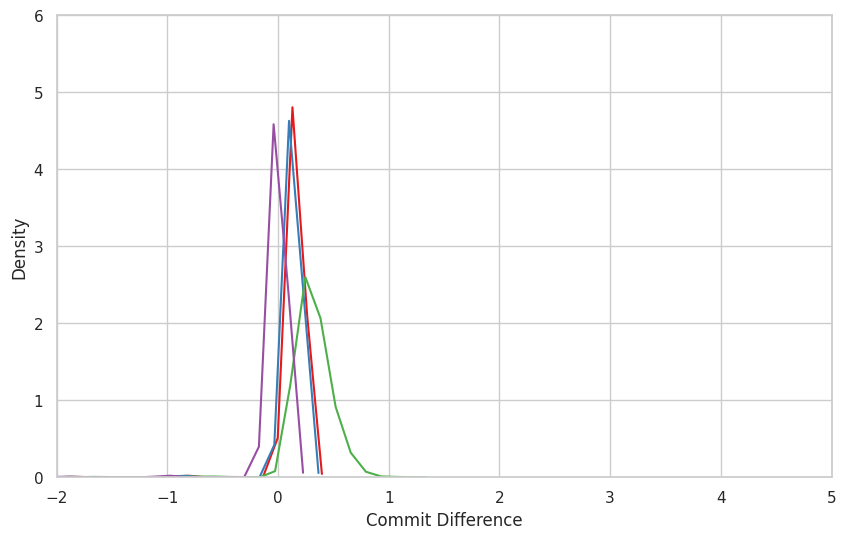


------XGBoost-----
MAPE (positive): 2.96%
MAPE (Round): 0.18%

------Random Forest-----
MAPE (positive): 2.75%
MAPE (Round): 0.34%

------LigthGBM-----
MAPE (positive): 2.99%
MAPE (Round): 0.16%

------Naive-----
MAPE (positive): 3.12%
MAPE (Round): 0.02%


In [241]:
# Create a new column for the difference between Commit Forecast and Commit Real
df_models['Commit Difference'] = df_models['Commit Forecast'] - df_models['Commit Real']
# Plot a histogram with KDE curves using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Set the number of bins to control the width
num_bins = 10

# Plot histogram
# Plot KDE curves
for model, color in zip(df_models['Model'].unique(), sns.color_palette("Set1", len(df_models['Model'].unique()))):
    sns.kdeplot(df_models[df_models['Model'] == model]['Commit Difference'], color=color, label=model)
# Show the plot
# Set y-axis limit
plt.ylim(0, 6)

# Set x-axis limit
plt.xlim(-2, 5)

# Show the plot
plt.show()

def calculate_mape_np(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    if len(actual) != len(forecast):
        raise ValueError("Length of 'actual' and 'forecast' must be the same.")

    # Calculate MAPE
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mape

def calculate_mape_positives(actual, forecast, epsilon=.0001):
    actual, forecast = np.array(actual), np.array(forecast)
    if len(actual) != len(forecast):
        raise ValueError("Length of 'actual' and 'forecast' must be the same.")

    # Calculate MAPE with smoothing factor
    mape = np.mean(np.abs((actual - forecast) / (actual + epsilon))) * 100

    return mape

def calculate_mape_positives(df_model):
    
    n = 0 
    total_abse = 0
    for i in df_model.index:
        obs = df_model.loc[i]
        real = obs['Commit Real'] 
        forecast=obs['Commit Forecast']
        if real!=0:
            n+=1
            if real !=forecast:
                metric = np.abs(real - forecast)
                total_abse+=metric
    return total_abse/n
        
        
def calculate_mape_np_round(df_model):
    
    n = len(df_model)
    total_abse = 0
    for i in df_model.index:
        obs = df_model.loc[i]
        real = obs['Commit Real'] 
        forecast=obs['Commit Forecast']
        if real !=forecast:
            metric = np.abs(real - forecast)
            total_abse+=metric
    return total_abse/n
        
    


model_list = ["XGBoost", "Random Forest", "LigthGBM", "Naive"  ]
for model in model_list:
    df_model = df_models[df_models.Model == model]
    
    MAPE = np.abs(df_model['Commit Difference'] )

    # Assuming 'Commit Difference' is already calculated in df_models
    actual_values = df_model['Commit Real']
    forecasted_values = df_model['Commit Forecast']
    # Calculate MAPE using NumPy
    #mape_result_np = calculate_mape_np(actual_values, forecasted_values)
    mape_result_epsilon = calculate_mape_positives(df_model)
    mape_result_round = calculate_mape_np_round(df_model)

    print(f"\n------{model}-----\nMAPE (positive): {mape_result_epsilon:.2f}%")
    print(f"MAPE (Round): {mape_result_round:.2f}%")

#### Plot 1:  Error distribution Anlaysis
One of the most important charactreistics of this problem is the heavy concentration of non reported values. As discussed in the Complete Series script and main.ipynb file, this happens because commits only happen during the creation of a repository and then they dacay as the project is completed. After that, only updates and patches are creted every now and then. Also it's important to mention that we draw our subsample of data out of the total population of commits and repositories, meannning that most of them are not production version of projects or mantained libraries, so we can expect to have a huge amount of almost empty repositories.

The first insight of the plot 1 is that most of the error fall arroun 0 as expected. Not only that, but we expect a lot of actual commits and predictions be exactly 0. This happens because a naive forecast that predicts 0 every time, happens to be a great prediction in terms in accuracy. For example, if 90% of the commit reported weeks is 0, then this algorithm will return a 90% MAPE.  

For this reason, here we explore an alternative verison of the MAPE where we assign whenever the repository AND forecast reported 0 at the same time only for the possitive reported weeks. The objective of the ensamble model is to correctly identify all the repositories that are not entirely 0 and the use that information in the ensemble model to create a better prediction.

## Model Evaluation - Repository Level
In this Section a Dashborad is presented that allows us to compare each model at a Repository level. By filtering the desired repository we can explore how the forecast performs in each repository. This dashboard, however, contains almost 98% of repositories with non reported commits over a period of one year. It will be difficult to find a repository that actually reports commits and the models identifying the trend of the commits. Still the results are correct and each model reports correctly at least 66% of the commit trend.

In [242]:

import pandas as pd
import plotly.express as px
from ipywidgets import interact, widgets

# Function for plotting
def plot_commits_over_time(df_models, selected_repositories, plot_size_factor=2):
    filtered_df = df_models[df_models['Repository'].isin(selected_repositories)]

    # Dynamic plot using Plotly
    fig = px.line(filtered_df, x='Date', y='Commit Forecast', color='Model', 
                  title='Commit Real over Time by Model and Repository',
                  labels={'Commit Forecast': 'Number of Commits'},
                  line_group='Model')  # Use 'Model' as hue

    fig.update_layout(xaxis_title='Date')

    # Increase plot size by 200%
    fig.update_layout(
        width=400 * plot_size_factor,
        height=250 * plot_size_factor
    )

    fig.update_traces(line_shape='linear')

    # Keep y-axis fixed at 5
    fig.update_yaxes(range=[0, 5])

    # Add bar plot for 'Commit Real'
    fig.add_bar(x=filtered_df['Date'], y=filtered_df['Commit Real'], name='Commit Real')

    fig.show()

# Load your data into a DataFrame
# df_models = pd.read_csv('your_data.csv')

repository_selector = widgets.SelectMultiple(
    options=df_models['Repository'].unique(),
    value=[df_models['Repository'].unique()[0]],
    description='Repositories'
)

# Set up interaction
interactive_plot = interactive(
    plot_commits_over_time,
    df_models=fixed(df_models),
    selected_repositories=repository_selector,
    plot_size_factor=(1, 3, 0.2)
)



In [243]:
interactive_plot

interactive(children=(SelectMultiple(description='Repositories', index=(0,), options=('CraftedCart/SMBWorkshop…

In [244]:
# Function for plotting
def plot_commits_mean(df_models, plot_size_factor=2):
    df_models_g = df_models.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
    df_models_g = df_models_g.reset_index()
    # Static plot using Matplotlib and Seaborn
    plt.figure(figsize=(10 * plot_size_factor, 6 * plot_size_factor))
    sns.lineplot(x='Date', y='Commit Real', hue='Model', data=filtered_df)
    plt.title('Commit Real over Time by Model and Repository')
    plt.show()

### Model Beahavior
The main objective of the ensamble model is to combine model that bahave differently trought time so the ensemble model can choose the best model for each cluster and for each season of the forecast. In the following section we plot the average commits per week to look at the trend followed by each model. Note: since the value of the y axis represents the average commits, the plots are not useful to undesrtand the predictive power of each model, but rather, the differienciate the pattern that each model follows

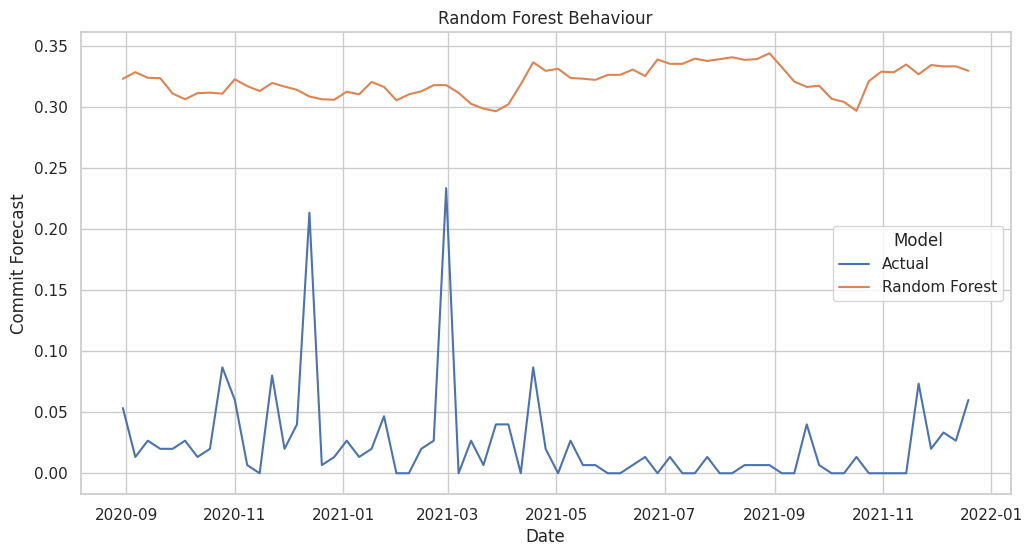

In [245]:

df_models_g = df_models.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
df_models_g = df_models_g.reset_index()
# Static plot using Matplotlib and Seaborn
plt.figure(figsize=(12 ,  6))
sns.lineplot(x='Date', y='Commit Forecast', hue='Model', data=df_models_g[ df_models_g.Model.isin(
    ["Random Forest", "Actual"])])
plt.title('Random Forest Behaviour')
plt.show()



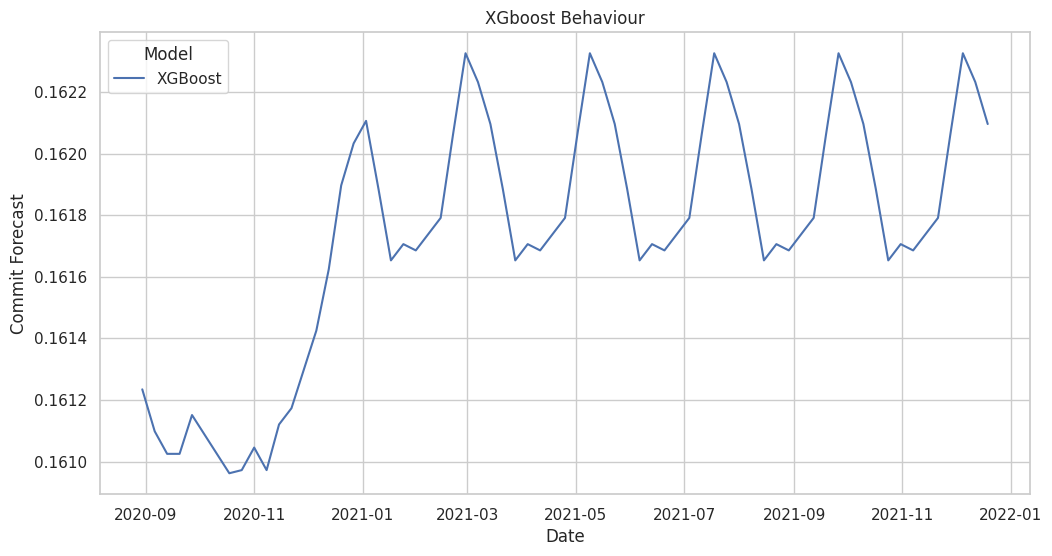

In [246]:

df_models_g = df_models.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
df_models_g = df_models_g.reset_index()
# Static plot using Matplotlib and Seaborn
plt.figure(figsize=(12 ,  6))
sns.lineplot(x='Date', y='Commit Forecast', hue='Model',  data=df_models_g[ df_models_g.Model.isin(
    ["XGBoost"])])
plt.title('XGboost Behaviour')
plt.show()


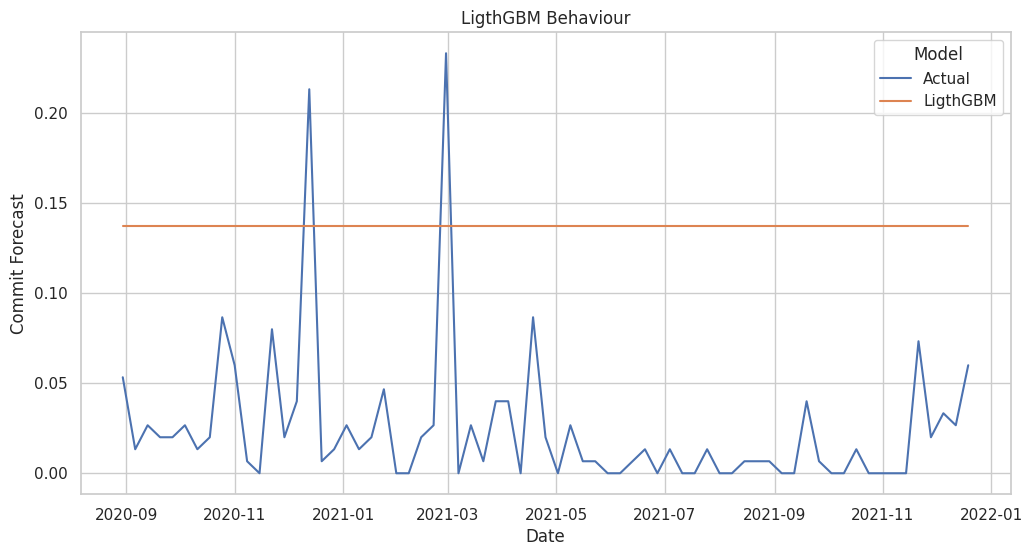

In [247]:
df_models_g = df_models.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
df_models_g = df_models_g.reset_index()
# Static plot using Matplotlib and Seaborn
plt.figure(figsize=(12 ,  6))
sns.lineplot(x='Date', y='Commit Forecast', hue='Model',  data=df_models_g[ df_models_g.Model.isin(
    ["LigthGBM", "Actual"])])
plt.title('LigthGBM Behaviour')
plt.show()

## Ensemble model - ElasticNet model
At the top of the forecast an Elastic model has been trainned that takes each previous prediction and then performs an average using additional variables.

* **Forecast Horizon**: Indicative variables that tells the elastic net how many weeks in the future is the next wave of prediction is ahead of the last reported week.
* **TimeSeries Cluster**:  A cluster algorithm that separates different trends of commit counts series. Each repository is assigned to one cluster out of 8 different clusters. For exmaple, cluster_0 represent all the repositories that reported 0 in most of their commit history.
* **Month Control variables**:  These dummies asign 1 or 0 deppending on the month of the weekly reported commits. There are 11 dummis, each one representing a different month.

All of these variables allows us to control by time, season and apply use the corect model (by changing the weigth) for each scenario. The Lasso and Ridge filtering get rid of unwanted variables that only create noise over the prediction and the final result is then passed to the front end to make a prediction over the selected repositories. This prediction takes some time to process but in exchange we provide the best prediction to identify potential uptrends in repositories commits. 


In [248]:
df_ensemble = pd.read_csv(f"src/githubmonitor/forecast/data/process/final_predictions.csv")
df_ensemble = df_ensemble[df_ensemble.model_family == "elasticnet"]
df_ensemble = df_ensemble.rename(columns = {"date":"Date", "model_family": "Model"})
df_ensemble.Date =  pd.to_datetime(df_ensemble.Date)
cut_date = pd.to_datetime("2021-12-26")
prediction_window = 104
lag_list = [2, 4, 6, 10]
rolling_list = [2, 4, 6]
evaluation_window = max(lag_list) + max(rolling_list) + 1

prediction_start = cut_date - timedelta(days=(prediction_window * 7))
prediction_end = cut_date
        
df_ensemble = df_ensemble[(df_ensemble.Date >= prediction_start)&(df_ensemble.Date <= prediction_end)]

In [249]:
df_compair = df_ensemble[df_ensemble.Model == "elasticnet"].copy()
df_compair["Model"] = "ElasticNet"
df_ensemble = pd.concat([df_ensemble,  df_compair])

df_compair = df_ensemble[df_ensemble.Model == "elasticnet"].copy()
df_compair["Model"] = "Naive"
df_ensemble["Commit Forecast"] = 0
df_ensemble = pd.concat([df_ensemble,  df_compair])

df_compair = df_ensemble[df_ensemble.Model == "elasticnet"].copy()
df_compair["Model"] = "Actual"
df_compair["Commit Forecast"] = df_compair["Commit Real"]
df_ensemble = pd.concat([df_ensemble,  df_compair])

### Cluster Analysis
To improve the performance of the algoriuthm a cluster based on TimeSeries cycles was created. The TimeSeriesKMeans algorithm is a variation of the classic k-means clustering algorithm but tailored for time series data. In k-means, the goal is to partition data into k clusters such that the sum of squared distances from each point to its assigned cluster center is minimized.

TimeSeriesKMeans takes into account the temporal (time-related) aspects of the data when forming clusters. This is important because the order of observations in time series data matters.

When looking at the results we can observe how the cluster algorith separates those repositories at dont report many commits (cluster 1) and those repositories with more frequent commits in a particular seasson (december for cluster 4 and Summer for clusetr 5). 

This is helpful information for the model to correctly apply the best prediction for each type of Series. 

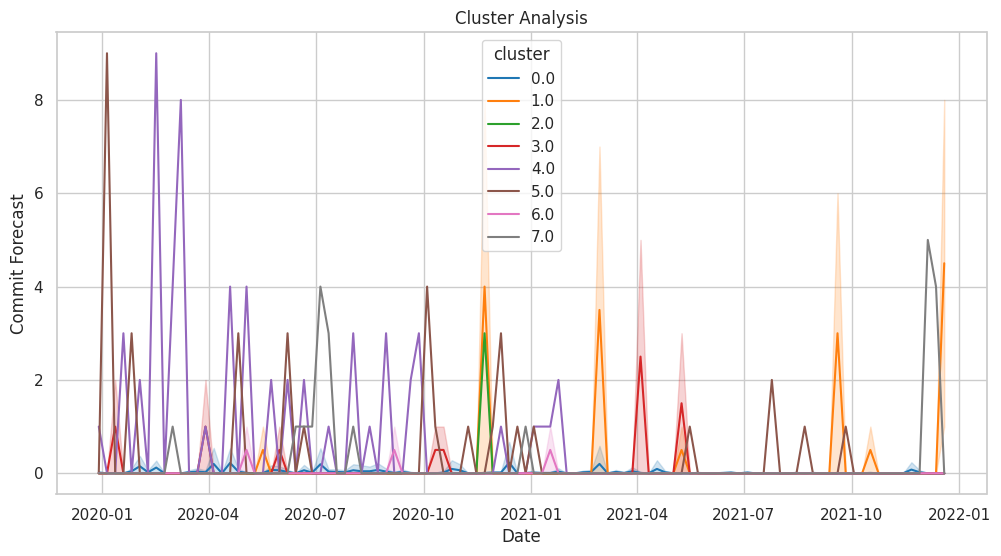

In [250]:
df_models_g = df_ensemble.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
df_models_g = df_ensemble.reset_index()
# Static plot using Matplotlib and Seaborn
color_palette = sns.color_palette("tab10", n_colors=8)
plt.figure(figsize=(12 ,  6))
sns.lineplot(x='Date', y='Commit Forecast', hue='cluster', data=df_models_g[df_models_g['Model'].isin(["Actual"])], palette=color_palette)
plt.title('Cluster Analysis')
plt.show()

### Ensemble Results
The follwing plot represent the results provided by the model for all the clusters. The objective of this plot is to provide information of how the cluster will behave for each type of repositoiry. Nonetheless, the ElasticNet seems to apply an homogeneous prediction based on 0 for most of the weeks.

There are many reasons of why this is happening but the most important is that we are using a MSE and MAPE evaluation metric to train and fit all the models. In this scenario is very difficult to beat the naive prediction (always 0) as 98% of the data report 0 commits (in the evaluation period). However, we can see how the Ensemble model outperforms by far all of the other models. 
 


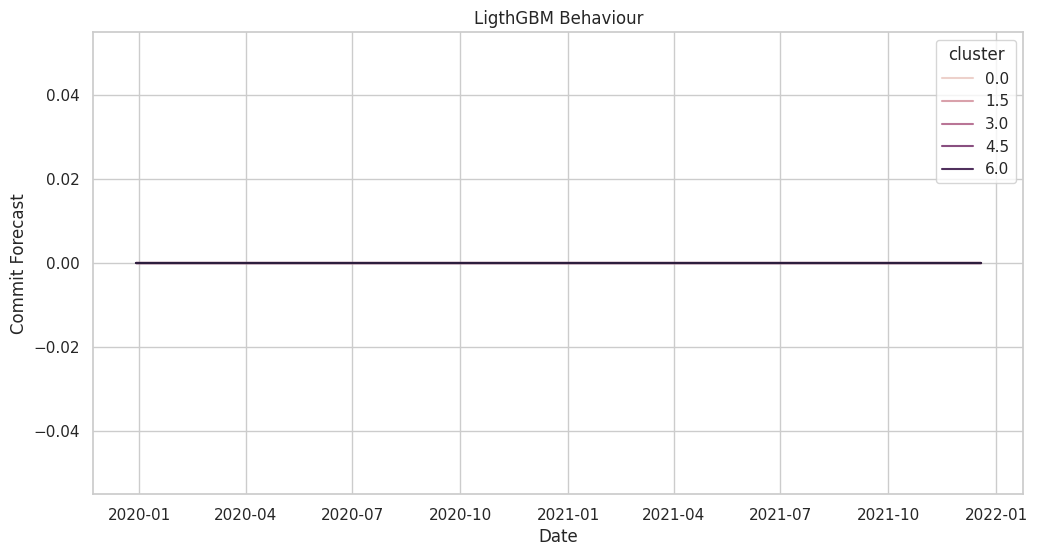

In [251]:
df_models_g = df_ensemble.groupby(["Date", "Model"])[["Commit Real", "Commit Forecast"]].mean()
df_models_g = df_ensemble.reset_index()
# Static plot using Matplotlib and Seaborn
plt.figure(figsize=(12 ,  6))
sns.lineplot(x='Date', y='Commit Forecast', hue='cluster',  data=df_models_g[ df_models_g.Model.isin(
    ["ElasticNet"])])
plt.title('LigthGBM Behaviour')
plt.show()

/tmp/ipykernel_175422/651695805.py:13: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/tmp/ipykernel_175422/651695805.py:13: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



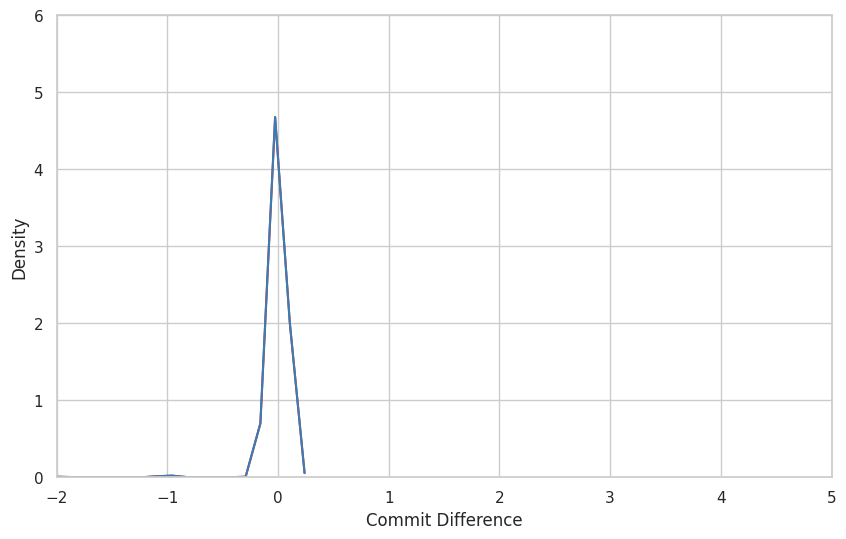


------elasticnet-----
MAPE (positive): 3.38%
MAPE (Round): 0.04%


In [252]:
# Create a new column for the difference between Commit Forecast and Commit Real
df_ensemble['Commit Difference'] = df_ensemble['Commit Forecast'] - df_ensemble['Commit Real']
# Plot a histogram with KDE curves using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Set the number of bins to control the width
num_bins = 10

# Plot histogram
# Plot KDE curves
for model, color in zip(df_ensemble['Model'].unique(), sns.color_palette("Set1", len(df_ensemble['Model'].unique()))):
    sns.kdeplot(df_ensemble[df_ensemble['Model'] == model]['Commit Difference'], color=color, label=model)
# Show the plot
# Set y-axis limit
plt.ylim(0, 6)

# Set x-axis limit
plt.xlim(-2, 5)

# Show the plot
plt.show()

    
model_list = ["elasticnet"  ]
for model in model_list:
    df_ensemble = df_ensemble[df_ensemble.Model == model]
    
    MAPE = np.abs(df_model['Commit Difference'] )

    # Assuming 'Commit Difference' is already calculated in df_models
    actual_values = df_ensemble['Commit Real']
    forecasted_values = df_ensemble['Commit Forecast']
    # Calculate MAPE using NumPy
    #mape_result_np = calculate_mape_np(actual_values, forecasted_values)
    mape_result_epsilon = calculate_mape_positives(df_ensemble)
    mape_result_round = calculate_mape_np_round(df_ensemble)

    print(f"\n------{model}-----\nMAPE (positive): {mape_result_epsilon:.2f}%")
    print(f"MAPE (Round): {mape_result_round:.2f}%")

# Conclusion and future work
In this exercise we use the prediction for all the different models of the ML pipeline and compare them with jthe actual values and a a Naive algorithm to study our results and create betetr prediction on an ensamble structure pipeline.

## Future Work: Improve the results 
There are many reason that make our final prediction not as good as the naive algorith. The huge percentage of non reported commits for most of the repositories is the most important one. However, this doesn't mean that the process is incorrect. As a matter of fact we would expect the ensemble model to be able to predict correctly for a longer evaluation and tarinnig set. In this exercsie only a 10th of a representative SUBSAMPLE of the total repositories was used and the models were trainned with one year of information. This was done for demostratiuon pruposes. With more computational power and time all the information can be feed to the individual and ensemble models to identify correctly the trend of the repositories. Furthermore, additional variables can be added to the pipeline including external data sources such as COVID trends, Tech companies stock behaviour and repository addhoc variables like user (or user level clusterization). 

This type of problem is particularly difficult to predict as we are facing data with a huge density of 0 reported values. But here are additional resource that can be deployed to improve the results of the forecast

* **Change Evaluation metric**: Change the RMSE default criterion of the models to a meric that punishes 0 commit forecast for non 0 commit observations. This will be similar to a precission metric for regression models. This is in fact the type of error we want to cover as we are trying to provide a good approximation of how the repositories will behave in the future (and all predictions will be biased in overreporting rather than subrerporting making it a good proxy for "repository popularity")
* **Increse teh size of the sample**:  As discussed previously, selecting more repositories will be very useful as only 2% of the total repositories present continious commit reports. 
* **Increase the evaluation perios*:  Tha nature of the problem is also challenging as al the repositories have a finite life cycle, so we are not only bias in selecting an small subset of the model but also cutting the and selecting a subsample of data with no commits reported (no mather were we cut the data, is most probably that we will cut the "active" period of the repository life cycle). Also by providing more data, seasonal and cluster variables will be able to correctly identify seasonal effects.
* **Inlcude external resources*: This application heavily relies in lag and moving average variables that simplify the forecast pipeline however, there are many more variables to inlcude in the mode such as exponential, diff and repository addhoc controls thatn can improve the result substantaillly.
* **Change the ensemble architecture*: Altough the selection of the head model (ElasticNet model) was startegically selected to avoid overfitting, the rest of the pipeline can be modiffied. For example, SVM can be included in the set of trainned models. The current project provides a general framework to add and train new models without changing most of the code. Add control variables to the first wave of models improving the indiviual performance of each model.
* **Reselect the Data**: In an scenario were we are evaluating repositories only in the "active" life cycle of the repository could lead to more insightful results. In this scenario, the naive approach will perform poorly while the graddient and bagging algirthms will have the most advantage.
